# Neural networks - straightforward guide

In [100]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, log_loss
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras

In [101]:
%matplotlib widget

# Kaggle
https://www.kaggle.com/uciml/pima-indians-diabetes-database

In [102]:
dataset = pd.read_csv('diabetes.csv')

In [103]:
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [104]:
dataset.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [105]:
data = dataset.values
X, Y = data[:,:-1], data[:,-1]

# Recap

In [106]:
rf = RandomForestClassifier(n_estimators=20, min_samples_leaf=3, max_features=0.5, n_jobs=-1, bootstrap=True)
rf.fit(X, Y)

accuracy_score(Y, rf.predict(X))

0.93359375

In [107]:
from sklearn.metrics import classification_report

print(classification_report(Y, rf.predict(X), target_names=['healthy', 'diabetic']))

              precision    recall  f1-score   support

     healthy       0.94      0.96      0.95       500
    diabetic       0.93      0.88      0.90       268

    accuracy                           0.93       768
   macro avg       0.93      0.92      0.93       768
weighted avg       0.93      0.93      0.93       768



<AxesSubplot:ylabel='cols'>

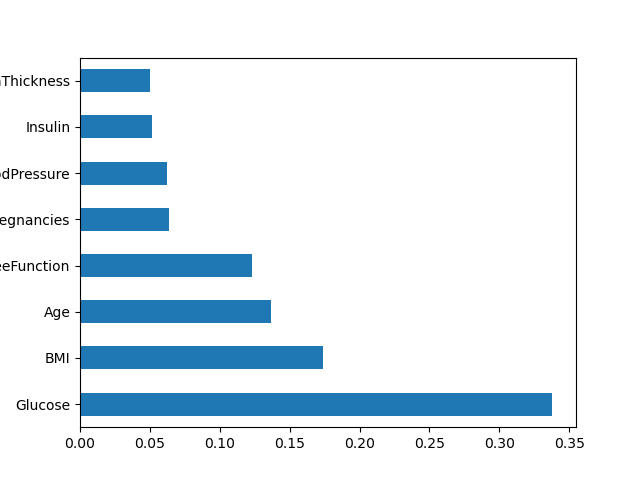

In [108]:
# %matplotlib widget
fi = pd.DataFrame({'cols':dataset.columns[:-1], 'imp':rf.feature_importances_}).sort_values('imp', ascending=False)
fi.plot('cols', 'imp', 'barh', legend=False)

In [109]:
# %matplotlib widget
sns.scatterplot(x='Glucose', y='BMI', hue='Outcome', data=dataset)

<AxesSubplot:xlabel='Glucose', ylabel='cols'>

# Train a neural network
https://keras.io/  
https://www.tensorflow.org/guide/keras

In [110]:
# Model prediction expressed as probabilities
rf.predict_proba(X[:10])

array([[0.10444444, 0.89555556],
       [0.965     , 0.035     ],
       [0.22428571, 0.77571429],
       [1.        , 0.        ],
       [0.2219246 , 0.7780754 ],
       [0.96      , 0.04      ],
       [0.41083333, 0.58916667],
       [0.54714286, 0.45285714],
       [0.08638889, 0.91361111],
       [0.54609307, 0.45390693]])

[Log loss visually explained](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a)

TL;DR:

$\huge H(y, pred) = -\frac{\sum_{i=1}^{N} y_ilog(pred_i) \ + \ (1 - y_i)log(1-pred_i)}{N}$

Because $y$ is always 0 or 1, it "toggles" the terms of the summation on/off and it could be rewritten as:
$\large -\frac{\sum_{i=1}^{N} log(1 - err_i)}{N}$

In [111]:
from sklearn.metrics import log_loss

log_loss(Y, rf.predict_proba(X)[:, 1])

0.23203567161881877

In [112]:
i = keras.layers.Input(shape=(X.shape[1],), name='input')
dense_1 = keras.layers.Dense(16, name='dense_1')(i)
dense_2 = keras.layers.Dense(8, name='dense_2')(dense_1)
out = keras.layers.Dense(1, activation='sigmoid', name='output')(dense_2)

neural_net = keras.Model(inputs=[i], outputs=[out])

In [113]:
neural_net.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['acc'])
neural_net.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 8)]               0         
                                                                 
 dense_1 (Dense)             (None, 16)                144       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 output (Dense)              (None, 1)                 9         
                                                                 
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________


In [114]:
callbacks = []
callbacks.append(keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=10))
callbacks.append(keras.callbacks.ModelCheckpoint('neural_net.h5', monitor='val_acc', mode='max',
                                                 save_weights_only=False, save_best_only=True))

history = neural_net.fit(x=X, y=Y, validation_split=.25, shuffle=True, batch_size=64, epochs=100, callbacks=callbacks)

Epoch 1/100
9/9 [==============================] - 0s 7ms/step - loss: 53.3159 - acc: 0.3438 - val_loss: 41.0748 - val_acc: 0.3646
Epoch 2/100
9/9 [==============================] - 0s 2ms/step - loss: 31.5829 - acc: 0.3542 - val_loss: 20.6032 - val_acc: 0.3698
Epoch 3/100
9/9 [==============================] - 0s 2ms/step - loss: 14.2430 - acc: 0.4444 - val_loss: 10.4326 - val_acc: 0.4948
Epoch 4/100
9/9 [==============================] - 0s 2ms/step - loss: 7.4918 - acc: 0.5885 - val_loss: 7.9142 - val_acc: 0.5990
Epoch 5/100
9/9 [==============================] - 0s 1ms/step - loss: 6.1841 - acc: 0.6319 - val_loss: 5.5481 - val_acc: 0.5990
Epoch 6/100
9/9 [==============================] - 0s 1ms/step - loss: 3.7842 - acc: 0.5833 - val_loss: 3.5264 - val_acc: 0.5000
Epoch 7/100
9/9 [==============================] - 0s 1ms/step - loss: 2.8861 - acc: 0.5156 - val_loss: 2.7825 - val_acc: 0.5104
Epoch 8/100
9/9 [==============================] - 0s 1ms/step - loss: 2.5463 - acc: 0.5312

In [115]:
# %matplotlib widget
plt.plot(history.history['loss'], label='train loss', marker='.')
plt.plot(np.array(history.epoch) + .5, 
         history.history['val_loss'], label='validation loss', marker='.')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

In [116]:
# %matplotlib widget
plt.plot(history.history['acc'], label='train accuracy', marker='.')
plt.plot(np.array(history.epoch) + .5, 
         history.history['val_acc'], label='validation accuracy', marker='.')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();

# Single-layer perceptron

In [117]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.arange(-5, 5, 0.1)

# %matplotlib widget
plt.plot(x, sigmoid(x))
plt.grid();

In [118]:
neural_net = keras.Sequential([
    keras.layers.InputLayer(input_shape=(X.shape[1],)),
    keras.layers.Dense(1, activation='sigmoid')
])

neural_net.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

history = neural_net.fit(x=X, y=Y, batch_size=32, epochs=100, verbose=False)

# %matplotlib widget
plt.plot(history.history['loss'], marker='.');

In [119]:
weights, bias = neural_net.layers[-1].get_weights()
weights.shape, bias.shape

((8, 1), (1,))

In [120]:
y_hat = sigmoid(np.dot(X, weights) + bias)

print(log_loss(Y, y_hat))
print(accuracy_score(Y, y_hat > 0.5))

0.5875815203186229
0.7109375


In [121]:
history.history['loss'][-1], history.history['accuracy'][-1]

(0.5940013527870178, 0.69921875)

# Gradient descent

In [122]:
def f(x):
    return x ** 2

def df(x):
    return x * 2

In [123]:
# %matplotlib widget
x = np.arange(-8, 8, 0.001)
plt.plot(x, f(x), color='k', label='f(x)')

xi = 8
lr = .2
steps = 3

projections = True
for i in range(steps):
    x_ip1 = xi - lr * df(xi)
    p_ip1 = f(xi) - lr * df(xi) * df(xi)
    y_ip1 = f(x_ip1)
    
    plt.plot([xi, x_ip1], [f(xi), y_ip1], marker='.', c='b')
    if projections:
        plt.plot([xi, x_ip1, x_ip1], [f(xi), p_ip1, y_ip1], ls='-.', alpha=.5, c='b')
    
    xi = x_ip1

Complicated functions, like neural nets, can be broken down into elementary functions that we know the derivatives to.

A layer like $\sigma(w \cdot x + b)$ would become $\sigma(\ add(\ mat\_mul(w, x), b))$

From there we apply the chain rule: $f(g(x))' = f'(g(x)) * g'(x)$

Training a neural network is performed through back-propagation, which involves applying the chain rule repeatedly until adjustments are made to all its weights. Fortunately libraries like Tensorflow and PyTorch handle all this busywork behind the scenes.

[Visualisations of neural networks training](https://playground.tensorflow.org/#activation=linear)

# Activation functions - extra decision power

In [124]:
def relu(x):
    return x * (x > 0)

# %matplotlib widget
plt.plot(x, relu(x))
plt.grid()

In [125]:
neural_net = keras.Sequential([
    keras.layers.InputLayer(input_shape=(X.shape[1],)),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

neural_net.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['acc'])
history = neural_net.fit(x=X, y=Y, validation_split=.25, batch_size=32, epochs=100, verbose=False)

In [126]:
# %matplotlib widget
plt.plot(history.history['acc'], label='train accuracy', marker='.')
plt.plot(np.array(history.epoch) + .5, 
         history.history['val_acc'], label='validation accuracy', marker='.')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();

# Scaling - using the same units

In [127]:
x1 = np.random.uniform(-100,100,100)
x2 = np.random.uniform(-1, 1, 100)

In [128]:
# %matplotlib widget
plt.scatter(x1, x2)

In [129]:
def scale(x):
    # the middle becomes 0
    # everything is expressed in terms of standard deviation
    return (x - np.mean(x)) / np.std(x)

# %matplotlib widget
plt.scatter(scale(x1), scale(x2))

In [130]:
scaler = StandardScaler()
data = dataset.values
X, Y = data[:,:-1], data[:,-1]

scaler.fit(X)
X_scaled = scaler.transform(X)

In [131]:
neural_net = keras.Sequential([
    keras.layers.InputLayer(input_shape=(X.shape[1],)),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

neural_net.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['acc'])
history = neural_net.fit(x=X_scaled, y=Y, validation_split=.25, batch_size=32, epochs=100, verbose=False)

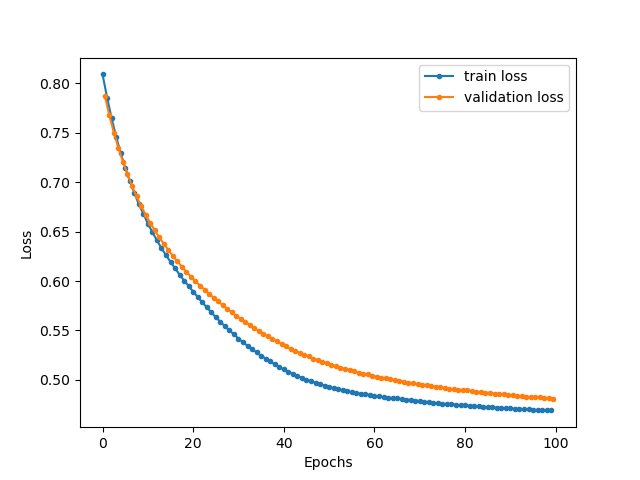

In [132]:
%matplotlib widget
plt.plot(history.history['loss'], label='train loss', marker='.')
plt.plot(np.array(history.epoch) + .5, 
         history.history['val_loss'], label='validation loss', marker='.')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

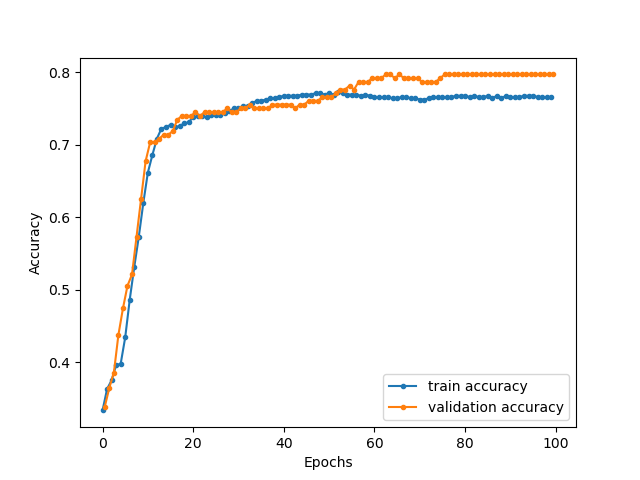

In [133]:
%matplotlib widget
plt.plot(history.history['acc'], label='train accuracy', marker='.')
plt.plot(np.array(history.epoch) + .5, 
         history.history['val_acc'], label='validation accuracy', marker='.')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();

# Train / Validation / Test
- Good practice https://dashee87.github.io/data%20science/deep%20learning/python/another-keras-tutorial-for-neural-network-beginners/

In [134]:
from sklearn.model_selection import train_test_split

# Store the scaler in a file; You'll need it to make predictions on new inputs
scaler = StandardScaler()
X_ = scaler.fit_transform(X)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_, Y, test_size=0.2, stratify=Y)
X_trn, X_val, Y_trn, Y_val = train_test_split(X_trn, Y_trn, test_size=0.25, stratify=Y_trn)

len(Y_trn), len(Y_val), len(Y_tst)

(460, 154, 154)

In [135]:
neural_net = keras.Sequential([
    keras.layers.InputLayer(input_shape=(X.shape[1],)),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [136]:
callbacks = []
callbacks.append(keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))
callbacks.append(keras.callbacks.ModelCheckpoint('neural_net.h5', monitor='val_acc',
                                                 save_weights_only=False, save_best_only=True))

neural_net.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['acc'])
neural_net.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 4)                 36        
                                                                 
 dense_22 (Dense)            (None, 4)                 20        
                                                                 
 dense_23 (Dense)            (None, 1)                 5         
                                                                 
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


In [137]:
history = neural_net.fit(X_trn, Y_trn, validation_data=(X_val, Y_val), batch_size=32, epochs=100, shuffle=False, callbacks=callbacks)

neural_net = keras.models.load_model('neural_net.h5')

Epoch 1/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8507 - acc: 0.3587 - val_loss: 0.7925 - val_acc: 0.4221
Epoch 2/100
15/15 [==============================] - 0s 2ms/step - loss: 0.8252 - acc: 0.3761 - val_loss: 0.7734 - val_acc: 0.4416
Epoch 3/100
15/15 [==============================] - 0s 953us/step - loss: 0.8036 - acc: 0.3870 - val_loss: 0.7574 - val_acc: 0.4416
Epoch 4/100
15/15 [==============================] - 0s 2ms/step - loss: 0.7851 - acc: 0.4022 - val_loss: 0.7439 - val_acc: 0.4610
Epoch 5/100
15/15 [==============================] - 0s 1ms/step - loss: 0.7691 - acc: 0.4087 - val_loss: 0.7320 - val_acc: 0.4935
Epoch 6/100
15/15 [==============================] - 0s 1ms/step - loss: 0.7550 - acc: 0.4152 - val_loss: 0.7217 - val_acc: 0.4935
Epoch 7/100
15/15 [==============================] - 0s 1ms/step - loss: 0.7427 - acc: 0.4413 - val_loss: 0.7129 - val_acc: 0.5000
Epoch 8/100
15/15 [==============================] - 0s 1ms/step - loss: 0.7318 -

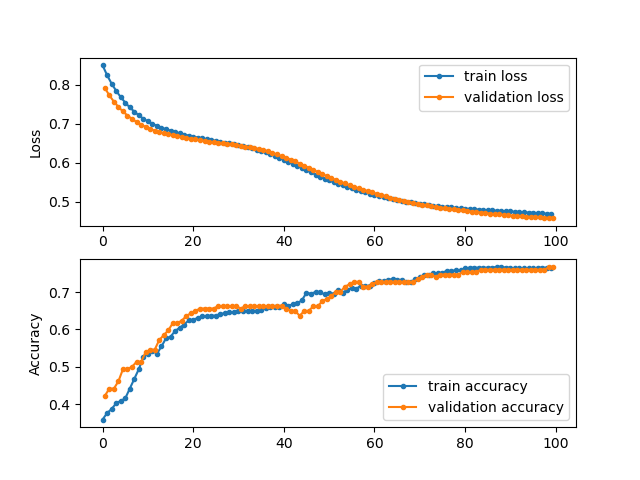

In [138]:
%matplotlib widget
fig, (ax0, ax1) = plt.subplots(nrows=2)

ax0.plot(history.history['loss'], label='train loss', marker='.')
ax0.plot(np.array(history.epoch) + .5, 
         history.history['val_loss'], label='validation loss', marker='.')
ax0.set_ylabel('Loss')
ax0.legend();

ax1.plot(history.history['acc'], label='train accuracy', marker='.')
ax1.plot(np.array(history.epoch) + .5, 
         history.history['val_acc'], label='validation accuracy', marker='.')
ax1.set_ylabel('Accuracy')
ax1.legend();

In [139]:
neural_net.evaluate(X_tst, Y_tst, verbose=False)

[0.5183652639389038, 0.7597402334213257]

In [140]:
print(classification_report(Y_tst, neural_net.predict(X_tst) > .5, target_names=['healthy', 'diabetic']))

              precision    recall  f1-score   support

     healthy       0.77      0.89      0.83       100
    diabetic       0.72      0.52      0.60        54

    accuracy                           0.76       154
   macro avg       0.75      0.70      0.72       154
weighted avg       0.75      0.76      0.75       154



# So only classification?

| Type of problem | Final activation function | Loss function | Useful metrics |
|:---|:---|:---|:---|
| Binary classification | sigmoid | binary_crossentropy | (binary_)accuracy, f1 score |
| Categorical classification | softmax | categorical_crossentropy | (categorical_)accuracy, f1 score|
| Multi-label classification | sigmoid | binary_crossentropy | binary_accuracy |
| (Multi-)Regression | linear, relu, ... | mse / mean_squared_error | R<sup>2</sup> (custom implementation) |

[Scikit-learn's metrics documentation](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

[TF.Keras losses documentation](https://www.tensorflow.org/api_docs/python/tf/keras/losses)

[TF.Keras metrics documentation](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)

# We're not done yet

In [141]:
from zipfile import ZipFile

with ZipFile('android.dat.zip', 'r') as f:
    f.extractall()
    
with open('android.dat', 'r') as f:
    android = json.load(f)
    
df = pd.DataFrame(android)
df

,verdict,activities,receivers,providers,services,md5,size,permissions,vcode
0,clean,4.0,0.0,1.0,0.0,32c68064d189be3258d5dd698df88e17,32100194,"[INTERNET, WRITE_EXTERNAL_STORAGE, ACCESS_NETW...",33
1,riskware,25.0,4.0,0.0,26.0,2f55e7604e2ef1e394470a988a85c426,411056,"[PACKAGE_USAGE_STATS, RECEIVE_SMS, WRITE_SMS, ...",1
2,clean,97.0,5.0,5.0,11.0,28099c074b8111181b79b41739c76d68,36722592,"[INTERNET, CAMERA, ACCESS_NETWORK_STATE, ACCES...",79
3,riskware,3.0,2.0,0.0,3.0,5a894801fd44294d0b2ef5c2f3264c2a,266169,"[READ_SMS, RECEIVE_SMS, RECORD_AUDIO, READ_EXT...",1
4,clean,16.0,0.0,0.0,0.0,ec6f136f213896fd2d9ebcde2da0e553,3371223,"[CAMERA, INTERNET, VIBRATE, FLASHLIGHT, READ_C...",17
...,...,...,...,...,...,...,...,...,...
31092,clean,53.0,7.0,5.0,10.0,c47508396aac9a062f24e261a77f1eb0,31849325,"[MOUNT_UNMOUNT_FILESYSTEMS, ACCESS_WIFI_STATE,...",10200
31093,clean,44.0,6.0,3.0,5.0,d020c30b700c95803d94f3844dc7cb98,16890758,"[INTERNET, ACCESS_NETWORK_STATE, ACCESS_WIFI_S...",134
31094,clean,99.0,9.0,9.0,13.0,c50f7c947c91220193e38765355525ed,31058991,"[INTERNET, ACCESS_WIFI_STATE, ACCESS_COARSE_LO...",12400
31095,clean,30.0,4.0,3.0,7.0,ddebbbc01e1e4d0cee1b833583f3c563,7075561,"[INTERNET, GET_ACCOUNTS, READ_PROFILE, READ_CO...",4


In [142]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
perms = mlb.fit_transform(df['permissions'])

len(mlb.classes_)

909

In [143]:
df_ = pd.concat([df, pd.DataFrame(perms, columns=mlb.classes_)], axis='columns').set_index('md5')
df_['permissions'] = df_['permissions'].apply(len)

X = df_.drop(columns=['verdict', 'vcode'])
y = df_['verdict']

X.describe()

,activities,receivers,providers,services,size,permissions,,ACCESS_COARSE_LOCATION,INTERACT_ACROSS_USERS,MANAGE_DOCUMENTS,...,sec.MDM_WIFI,sec.RECEIVE_BLOCKED_SMS_MMS,sec.SMIME_CERTIFICATE,status_bar,use_fingerprint,w,wake_lock,write_apn_settings,write_calendar,write_secure_settings
count,31097.000000,31097.000000,31097.000000,31097.000000,3.109700e+04,31097.000000,31097.000000,31097.000000,31097.000000,31097.000000,...,31097.000000,31097.000000,31097.000000,31097.000000,31097.000000,31097.000000,31097.000000,31097.000000,31097.000000,31097.000000
mean,39.245426,5.338875,2.476509,8.247452,1.805938e+07,14.126765,0.000225,0.000064,0.000064,0.000032,...,0.000772,0.000386,0.000225,0.000032,0.000032,0.000032,0.000032,0.000257,0.000032,0.000032
std,75.024134,6.465626,4.863856,10.465661,2.351635e+07,11.568139,0.015002,0.008020,0.008020,0.005671,...,0.027771,0.019641,0.015002,0.005671,0.005671,0.005671,0.005671,0.016038,0.005671,0.005671
min,0.000000,0.000000,0.000000,0.000000,4.637000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,1.000000,0.000000,1.000000,3.409126e+06,6.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,14.000000,4.000000,1.000000,5.000000,1.004509e+07,11.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,42.000000,7.000000,3.000000,12.000000,2.292024e+07,21.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1058.000000,159.000000,109.000000,210.000000,2.901789e+08,124.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
